# Reference
* https://github.com/nikitaa30/Recommender-Systems/blob/master/knn_recommender.py
* https://heartbeat.fritz.ai/recommender-systems-with-python-part-ii-collaborative-filtering-k-nearest-neighbors-algorithm-c8dcd5fd89b2

In [3]:
import os
import pandas as pd

data_path = '../data/ml-25m/'
movies_filename = 'movies.csv'
ratings_filename = 'ratings_500000.csv'

In [4]:
df_movies = pd.read_csv(
    os.path.join(data_path, movies_filename),

    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [5]:
df_movies.head()
df_movies.shape

(62423, 2)

In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [7]:
df_ratings=df_ratings[:2000000]

In [8]:
df_ratings.shape

(499999, 3)

In [9]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

In [10]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [11]:
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,3436,3437,3438,3439,3440,3441,3442,3443,3444,3445
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,4.0,0.0,0.0,4.0,0.0,3.5,...,0.0,5.0,0.0,0.0,0.0,0.0,4.0,3.5,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [13]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 3445 unique users and 17466 unique movies in this data set


In [15]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,7569
1.0,14443
1.5,8484
2.0,32295
2.5,24986
3.0,97143
3.5,62535
4.0,134700
4.5,43600


In [16]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,59670371
0.5,7569
1.0,14443
1.5,8484
2.0,32295
2.5,24986
3.0,97143
3.5,62535
4.0,134700
4.5,43600


In [17]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,59670371,17.904346
0.5,7569,8.931816
1.0,14443,9.577965
1.5,8484,9.045937
2.0,32295,10.382668
2.5,24986,10.126071
3.0,97143,11.483939
3.5,62535,11.043482
4.0,134700,11.810805
4.5,43600,10.682812


Text(0,0.5,'number of ratings')

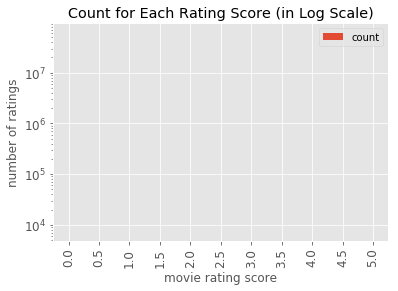

In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

get_ipython().run_line_magic('matplotlib', 'inline')
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [22]:
# get rating frequency
#number of ratings each movie got.
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,1167
2,475
3,281
4,37
5,249


In [23]:
#now we need to take only movies that have been rated atleast 50 times to get some idea of the reactions of users towards it

popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (499999, 3)
shape of ratings data after dropping unpopular movies:  (392982, 3)


In [24]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,31
2,169
3,536
4,202
5,92


In [25]:
# filter data to come to an approximation of user likings.
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (499999, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (348732, 3)


In [26]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [28]:
movie_user_mat_sparse# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [30]:
from fuzzywuzzy import fuzz

/Users/aoi/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [31]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [32]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: movie-user matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [33]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Dark Knight Rises, The (2012), with distance of 0.3972262144088745
2: Avatar (2009), with distance of 0.3901596665382385
3: Inception (2010), with distance of 0.3873627185821533
4: Batman Begins (2005), with distance of 0.38314497470855713
5: WALL·E (2008), with distance of 0.3784911036491394
6: Guardians of the Galaxy (2014), with distance of 0.3737345337867737
7: Star Trek (2009), with distance of 0.36319971084594727
8: Iron Man 2 (2010), with distance of 0.35760819911956787
9: Avengers, The (2012), with distance of 0.3324636220932007
10: Dark Knight, The (2008), with distance of 0.29112935066223145


In [34]:
movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Father of the Bride Part II (1995)': 3,
 'Heat (1995)': 4,
 'Sabrina (1995)': 5,
 'Sudden Death (1995)': 6,
 'GoldenEye (1995)': 7,
 'American President, The (1995)': 8,
 'Dracula: Dead and Loving It (1995)': 9,
 'Nixon (1995)': 10,
 'Casino (1995)': 11,
 'Sense and Sensibility (1995)': 12,
 'Four Rooms (1995)': 13,
 'Ace Ventura: When Nature Calls (1995)': 14,
 'Money Train (1995)': 15,
 'Get Shorty (1995)': 16,
 'Copycat (1995)': 17,
 'Assassins (1995)': 18,
 'Powder (1995)': 19,
 'Leaving Las Vegas (1995)': 20,
 'Othello (1995)': 21,
 'Persuasion (1995)': 22,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 23,
 'Dangerous Minds (1995)': 24,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 25,
 'Babe (1995)': 26,
 'Dead Man Walking (1995)': 27,
 'Clueless (1995)': 28,
 'Richard III (1995)': 29,
 'Mortal Kombat (1995)': 30,
 'To Die For (1995)': 31,
 'How to Make an American Quilt (1995)': 